# An example combined raster/vector workflow

This notebook uses several features of the AVL exploitation system to demonstrate a combined raster and vector workflow. It uses agriculturally relevant data from the Belgian Land Parcel Identification System (LPIS) and SEN-ET data generated in the AVL’s thematic processing system; however, the focus is on showing common processing steps and workflows rather than producing scientifically useful results.

## Set up the notebook

First we import some necessary libraries and preset a sensible size for the figures.

In [1]:
import sys
from xcube.core.store import new_data_store
from xcube_geodb.core.geodb import GeoDBClient
from xcube.core.geom import rasterize_features
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime

plt.rcParams['figure.figsize'] = 16,12

## Create a data store and list the available datasets

Our SEN-ET data come from an AVL object storage bucket. To read the data, we open an xcube data store with the desired bucket as its root.

In [2]:
store = new_data_store('s3', root='agriculture-vlab-data-staging',
                       max_depth=5, storage_options=dict(anon=True))

Now we list the available datasets in the bucket.

In [3]:
list(store.get_data_ids())

['avl/l2a-s1/2019/bel/S1_L2_BCK_VH.zarr',
 'avl/l2a-s1/2019/bel/S1_L2_BCK_VV.zarr',
 'avl/l2a-s1/2019/bel/S1_L2_COH_VH.zarr',
 'avl/l2a-s1/2019/bel/S1_L2_COH_VV.zarr',
 'avl/l2a-s1/2019/fra/S1_L2_BCK_VH.zarr',
 'avl/l2a-s1/2019/fra/S1_L2_BCK_VV.zarr',
 'avl/l2a-s1/2019/fra/S1_L2_COH_VH.zarr',
 'avl/l2a-s1/2019/fra/S1_L2_COH_VV.zarr',
 'avl/l2a-s1/2020/bel/S1_L2_BCK_VH.zarr',
 'avl/l2a-s1/2020/bel/S1_L2_BCK_VV.zarr',
 'avl/l2a-s1/2020/bel/S1_L2_COH_VH.zarr',
 'avl/l2a-s1/2020/bel/S1_L2_COH_VV.zarr',
 'avl/l3b/2019/bel/S2_L3B.zarr',
 'avl/l3b/2019/bel/S2_L3B_FAPAR.zarr',
 'avl/l3b/2019/bel/S2_L3B_FCOVER.zarr',
 'avl/l3b/2019/bel/S2_L3B_LAI.zarr',
 'avl/l3b/2019/bel/S2_L3B_NDVI.zarr',
 'avl/l3b/2019/fra/S2_L3B.zarr',
 'avl/l3b/2019/fra/S2_L3B_FAPAR.zarr',
 'avl/l3b/2019/fra/S2_L3B_FCOVER.zarr',
 'avl/l3b/2019/fra/S2_L3B_LAI.zarr',
 'avl/l3b/2019/fra/S2_L3B_NDVI.zarr',
 'avl/l3b/2020/bel/S2_L3B.zarr',
 'avl/l3b/2020/bel/S2_L3B_FAPAR.zarr',
 'avl/l3b/2020/bel/S2_L3B_FCOVER.zarr',
 'avl/l3b/

## Read Belgian evapotranspiration data from the thematic processing system and display it

Open a dataset containing SEN-ET data from 2020 for the 31UFR Sentinel tile (southern Belgium). Note that the dataset opens quickly because no data is being read yet: data reading and processing occur lazily, i.e. only when they become necessary.

In [4]:
cube = store.open_data('avl/senet/2020/bel-new/EVAPOTRANSPIRATION_SENET_31UFR.zarr')

Now plot a map of the evapotranspiration data from this dataset at a particular time point.

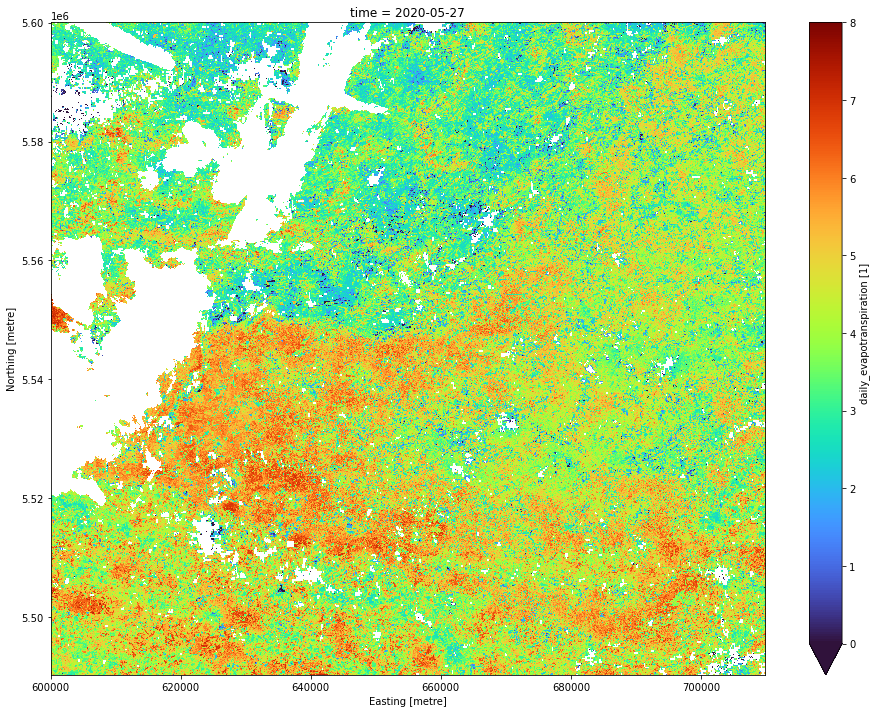

In [5]:
cube.daily_evapotranspiration.isel(time=10).plot.imshow(vmin=0, vmax=8, cmap='turbo')

## Create a small, zoomed-in sub-cube

To be able to look at individual land parcels, we create a data cube for a small (0.1° × 0.1°) sub-region of the tile and plot the data again.

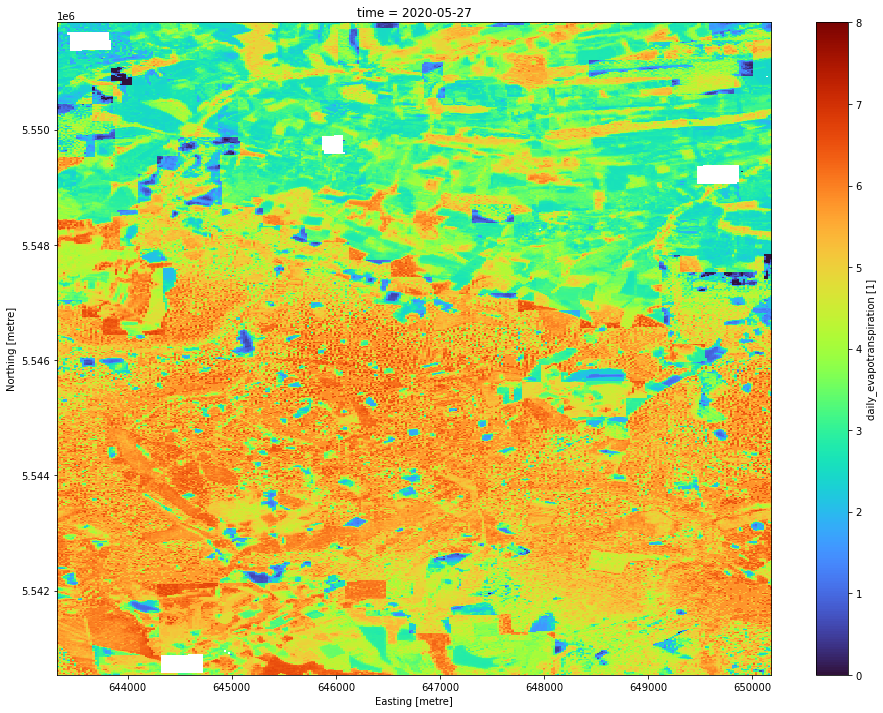

In [6]:
bbox = [5, 50, 5.1, 50.1]
geodb = GeoDBClient()
bbox_utm = geodb.transform_bbox_crs(bbox=bbox, from_crs=4326, to_crs=32631)
cube_small = cube.sel(x=slice(bbox_utm[0], bbox_utm[2]), y=slice(bbox_utm[3], bbox_utm[1]))

cube_small.daily_evapotranspiration.isel(time=10).plot.imshow(vmin=0, vmax=8, cmap='turbo')

## Get the corresponding vector LPIS data from geoDB and reproject it into the cube’s CRS

Now we’ll try combining these data with vector data from the LPIS. First we use the geoDB client to get the data for our sub-cube’s bounding box and reproject it to the same CRS.

In [7]:
gdf = geodb.get_collection_by_bbox(collection='lpis_wallonia_full', database='avl', 
                                   bbox=bbox, comparison_mode='intersects',
                                   bbox_crs=4326)

In [8]:
gdf_utm = gdf.to_crs(epsg=32631)

We can use the `head` function to take a quick look at a few data rows. Each row represents one land parcel. Note the `cult_cod` and `cult_nom` columns: these identify the land use (in most cases, a crop or vegetation type) as a reference number and a text string (in French), respectively.

In [9]:
gdf_utm.head()

,id,created_at,modified_at,geometry,objectid,campagne,cult_cod,cult_nom,groupe_cul,surf_ha
0,988,2022-05-03T12:43:38.475151+00:00,None,"POLYGON ((645920.850 5549525.827, 645937.718 5...",988,2020,6,Prairie et fourrage,Production fourragère,0.7987
1,1038,2022-05-03T12:43:40.481375+00:00,None,"POLYGON ((647574.344 5541157.057, 647584.499 5...",1038,2020,6,Prairie et fourrage,Production fourragère,2.6666
2,1307,2022-05-03T12:43:40.481375+00:00,None,"POLYGON ((647093.542 5541717.427, 647192.945 5...",1307,2020,743,Autres fourrages,Production fourragère,0.5371
3,1421,2022-05-03T12:43:40.481375+00:00,None,"POLYGON ((648420.624 5544982.885, 648425.800 5...",1421,2020,6,Prairie et fourrage,Production fourragère,3.7095
4,1958,2022-05-03T12:43:40.481375+00:00,None,"POLYGON ((647575.037 5550015.102, 647524.586 5...",1958,2020,6,Prairie et fourrage,Production fourragère,1.3225


## Rasterize the vector LPIS data into a new cube variable

Now we use xcube’s `rasterize_features` function to create a new variable in the data cube with the crop type taken from the vector LPIS data.

In [10]:
rasterize_features(cube_small, gdf_utm, ['cult_cod'], in_place=True)

<xarray.Dataset>
Dimensions:                   (time: 38, y: 566, x: 343)
Coordinates:
  * time                      (time) datetime64[ns] 2020-01-01 ... 2020-12-18
  * x                         (x) float32 6.433e+05 6.434e+05 ... 6.502e+05
  * y                         (y) float32 5.552e+06 5.552e+06 ... 5.541e+06
Data variables:
    crs                       int32 ...
    daily_evapotranspiration  (time, y, x) float32 dask.array<chunksize=(1, 566, 343), meta=np.ndarray>
    cult_cod                  (y, x) float64 dask.array<chunksize=(566, 343), meta=np.ndarray>
Attributes: (12/22)
    Conventions:              CF-1.7
    geospatial_bounds:        POLYGON((600000.0 5600040.0, 600000.0 5490240.0...
    geospatial_bounds_crs:    PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",...
    geospatial_lat_max:       50.54373917381065
    geospatial_lat_min:       49.52841829395487
    geospatial_lat_units:     degrees_north
    ...                       ...
    geospatial_y_units:       metre
    keywords:                 ESA, AVL, Agriculture, EO
    sources:                  ['EVAPOTRANSPIRATION_SENET_31UFR_20200101.ZARR'...
    summary:                  This dataset is used to demonstrate the AVL com...
    time_coverage_start:      2020-01-01 00:00:00
    title:                    Agricultural Virtual Laboratory Dataset

Now we can plot a map with the LPIS crop type codes shown as different colours, to get an impression of the variety of different crops. The LPIS codes cover a wide, sparse range unevenly; as a quick fix to get a more even distribution across the colour scale, we apply a modulo function to transform them into a much smaller range. This might make some colours ambiguous, but it’s useful for providing a quick, rough view.

In [11]:
cube_small['cult_display'] = cube_small.cult_cod % 51

Now plot the LPIS categories.

/opt/conda/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in remainder
  return func(*(_execute_task(a, cache) for a in args))


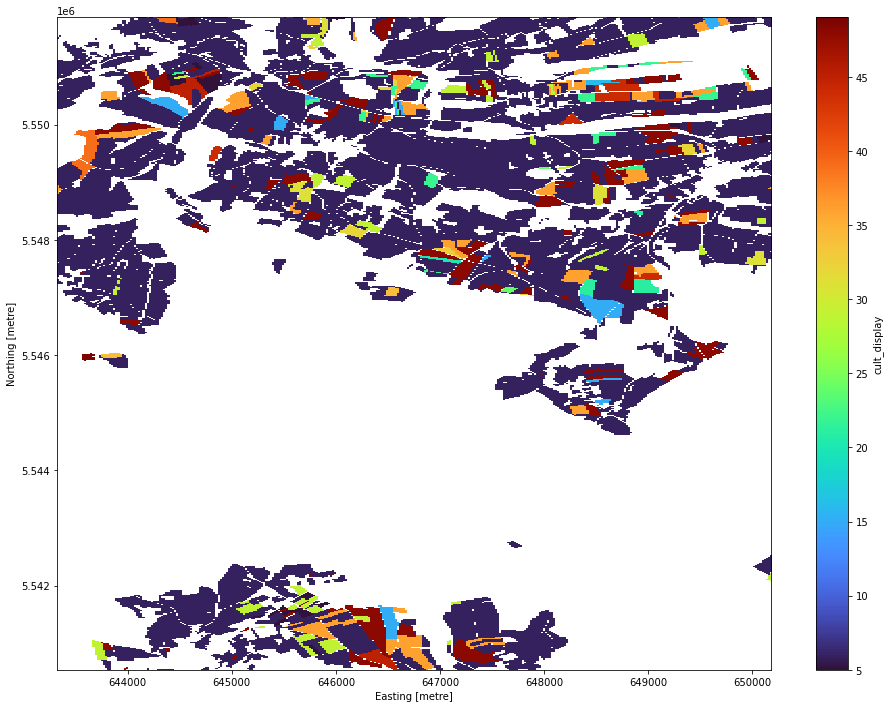

In [12]:
cube_small.cult_display.plot.imshow(cmap='turbo')

## Add another new variable: evapotranspiration, masked to the LPIS parcels

We add another variable to the data cube: a copy of the SEN-ET data, but masked to the rasterized LPIS parcels, so we can show SEN-ET just for identified land parcels.

In [13]:
cube_small['et_masked'] = cube_small.daily_evapotranspiration.where(cube_small.cult_cod > 0)

In many places on the plot, we can see that differences in land use categories plotted above correspond to significant differences in the evapotranspiration rate, as we’d expect. Frequently the edges of the land parcels can be seen clearly as discontinuities in evapotranspiration values.

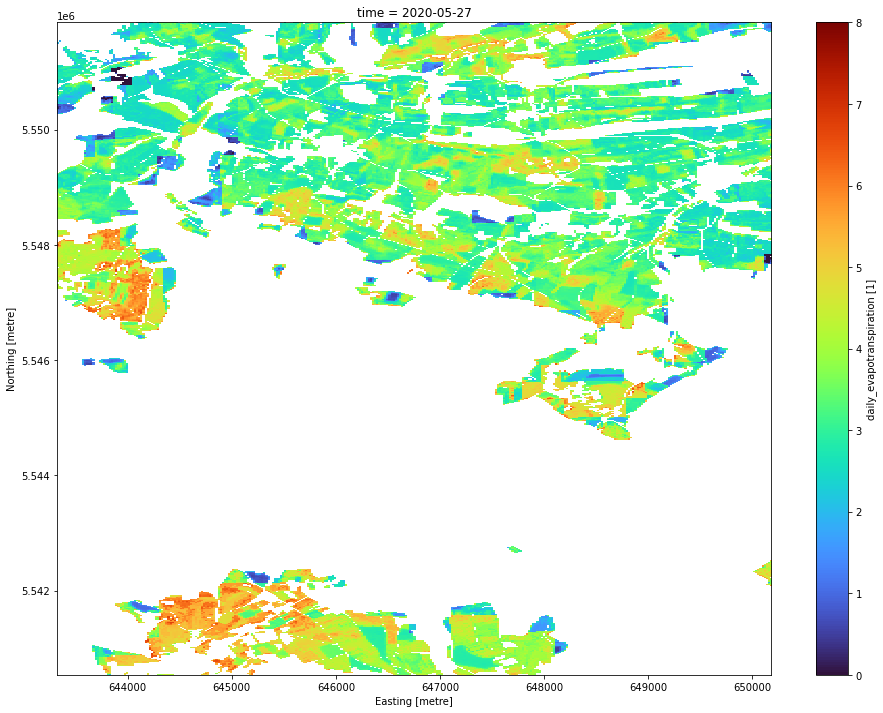

In [14]:
cube_small.et_masked.isel(time=10).plot.imshow(vmin=0, vmax=8, cmap='turbo')

## Save the data to AVL object storage, so that we can see it in the viewer

Finally, we write the manipulated cube to the public user data store, where we can share it with other users and explore it further in the xcube viewer. We write the data as a Zarr, and add a date/time suffix to the identifier to make it unique.

In [15]:
d = datetime.now()
public_store_write.write_data(data=cube_small, data_id='demo-notebook-4-cube-' + d.strftime("%Y%m%d-%H-%M-%S") + '.zarr')

/opt/conda/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in remainder
  return func(*(_execute_task(a, cache) for a in args))


'demo-notebook-4-cube-20220801-15-09-10.zarr'